In [145]:
from selenium import webdriver
import pandas as pd
import re
import matplotlib.pyplot as plt
import numpy as np

# dangerous but dirty hack to let me get csv from nytimes github
import ssl
ssl._create_default_https_context = ssl._create_unverified_context 

In [101]:
browser = webdriver.Firefox(executable_path='/usr/local/bin/geckodriver')

## Scrape stay at home orders

In [102]:
url = 'https://www.nytimes.com/interactive/2020/us/coronavirus-stay-at-home-order.html?smid=ig-nytimes&utm_source=like2buy.curalate.com&crl8_id=3b7a7632-c666-4d1b-955d-e8cadc22aaae'
browser.get(url)

order_nodes = browser.find_elements_by_xpath("//div[starts-with(@id, 'item-')]")
print('States that have issued orders: ' + str(len(order_nodes)))

In [178]:
def get_place_name(node, type_of_node=None):
    if type_of_node == 'state':
        node = node.find_element_by_tag_name('h3')
    name = node.text
    children = node.find_elements_by_xpath('./*')
    for child in children: 
        name = name.replace(child.text, '').strip()
    return name
    
def format_order(order):
    return order.text.split(',')[0].lower()

def format_date(date):
    text = re.search('[A-Z]\w* \d*', date.text)[0]
    month = text.split(' ')[0][:3]
    day = text.split(' ')[1]
    return month + ' ' + day

In [179]:
data = {'state': [], 'place': [], 'order': [], 'date': []}

for order_node in order_nodes:
    state_name = get_place_name(order_node, 'state')
    places = order_node.find_elements_by_class_name('l-place')
    orders = order_node.find_elements_by_class_name('l-order')
    dates = order_node.find_elements_by_class_name('l-date')                        
    
    if not places:
        data['state'].append(state_name)
        data['place'].append(None)
        data['order'].append(format_order(orders[0]))
        data['date'].append(format_date(dates[0]))
    else:
        for i, place in enumerate(places):
            data['state'].append(state_name)
            data['place'].append(get_place_name(place))
            data['order'].append(format_order(orders[i]))
            data['date'].append(format_date(dates[i]))

In [229]:
orders = pd.DataFrame(data)
orders

,state,place,order,date
0,Alabama,Birmingham,shelter in place,Mar 24
1,Alaska,None,stay at home,Mar 28
2,Arizona,None,stay at home,Mar 31
3,California,None,stay at home,Mar 19
4,Colorado,None,stay at home,Mar 26
...,...,...,...,...
148,Virginia,None,stay at home,Mar 30
149,Washington,None,stay at home,Mar 23
150,West Virginia,None,stay at home,Mar 24
151,Wisconsin,None,stay at home,Mar 25


Collect all the state-level orders:

In [232]:
state_orders = orders[orders['place'].isna()]
len(state_orders)

35

## Load cases data

Will need to load counties or something to account for places in the stay at home orders.

In [126]:
state_cases = pd.read_csv('https://raw.githubusercontent.com/nytimes/covid-19-data/master/us-states.csv')

In [127]:
state_cases

,date,state,fips,cases,deaths
0,2020-01-21,Washington,53,1,0
1,2020-01-22,Washington,53,1,0
2,2020-01-23,Washington,53,1,0
3,2020-01-24,Illinois,17,1,0
4,2020-01-24,Washington,53,1,0
...,...,...,...,...,...
1549,2020-03-30,Virginia,51,1021,26
1550,2020-03-30,Washington,53,5179,221
1551,2020-03-30,West Virginia,54,145,1
1552,2020-03-30,Wisconsin,55,1267,20


In [193]:
def format_date(df, start):
    months = ['Jan', 'Feb', 'Mar', 'Apr', 'May']
    x = [] # dates
    for i in list(df['date'].str.split('-')):
        date = months[int(i[1]) - 1] + ' ' + str(int(i[2]))
        x.append(date)
    return x

In [132]:
ny = state_cases[state_cases['state'] == 'New York']
ny

,date,state,fips,cases,deaths
246,2020-03-01,New York,36,1,0
261,2020-03-02,New York,36,1,0
276,2020-03-03,New York,36,2,0
293,2020-03-04,New York,36,11,0
313,2020-03-05,New York,36,22,0
338,2020-03-06,New York,36,44,0
369,2020-03-07,New York,36,89,0
404,2020-03-08,New York,36,106,0
440,2020-03-09,New York,36,142,0
478,2020-03-10,New York,36,173,0


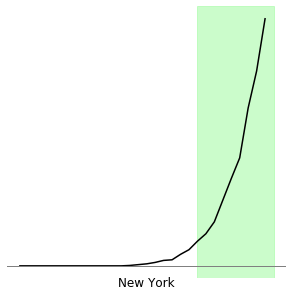

In [234]:
dates = format_date(ny, 1)

plt.figure(figsize=(5, 5))
plt.plot(dates, ny['deaths'], color='black')
ax = plt.gca()

#ax.set_xticks(np.arange(0, len(ny_dates), 6))

ax.axvspan(ny_dates.index(ny_order[0]), len(ny_dates), alpha=0.5, color='#98FB98')
ax.axhline(0, color='gray', lw=1)
ax.axis('off')
plt.title('New York', y=-0.05)

plt.show()